In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../src/')
import helpers as h
%matplotlib inline

In [2]:
def get_data_msp(file_list, r_list, n_samples):
    '''Import msprime simulation data and scale distances and SFS by pi'''
    num_r = len(r_list)
    
    data = h.import_msprime_corr(file_list, n_samples)
    pi, sfs, jsfs, pi_corr, lolo_corr, lohi_corr, hihi_corr = data
    
    d = np.tile(r_list, len(file_list)//len(r_list)) * pi / 2
    d = d.reshape((-1,num_r))
    
    sfs /= pi[:,None]
    sfs = sfs.reshape((-1, num_r, sfs.shape[-1]))
    
    lohi_corr = lohi_corr.reshape((-1, num_r, lohi_corr.shape[-1]))
    
    return d, sfs, lohi_corr

In [3]:
def get_data_slim(fn):
    '''Import slim simulation data and scale distances and SFS by pi'''
    data = h.readcorr_normed(fn, n_samples)
    pi, sfs, _, _, lohi_corr, _ = data
    sfs /= pi
    d = dist*r_slim*pi / (2*mu)
    return d, sfs, lohi_corr

## Import msprime data

In [4]:
# Sample size
n_samples = 100
# Beta coalescent alpha parameter
a_list = [2.0, 1.75, 1.5, 1.25]
# Exp growth parameter
g_list = [1.0, 2.0, 4.0, 8.0]
# Piecewise-constant growth time and inverse growth factor
t_list = [0.01, 0.1, 1.0]
s_list = [0.2, 0.1, 0.05, 0.01]

In [5]:
# Recombination rates (Piecewise-constant uses higher recombination rates because it has higher coalescent rates.)
r_list = np.insert(np.logspace(-1,3,13), 0, 0.0)
r_list_beta = r_list[:-3]
r_list_exp = r_list[:-3]
r_list_pwc = r_list

In [6]:
head = '../simulations/msprime/jsfs_n-{}_'.format(n_samples)

In [7]:
# Get the beta coalescent results
r_list_beta = r_list[:-3]
file_list_beta = [head + 'a-{}_r-{}.txt'.format(a, r) for a in a_list for r in r_list_beta]
data_beta = get_data_msp(file_list_beta, r_list_beta, n_samples)

# The first entries in data_beta are for the Kingman coalescent with no growth.
# This will be used as a global variable for plotting
d_kingman = data_beta[0][0]
lhc_kingman = data_beta[2][0]
data_beta = tuple(datum[1:] for datum in data_beta)

In [8]:
file_list_exp = [head + 'g-{}_r-{}.txt'.format(g, r) for g in g_list for r in r_list_exp]
data_exp = get_data_msp(file_list_exp, r_list_exp, n_samples)

In [9]:
file_list_pwc = [head + 'T-{}_S-{}_r-{}.txt'.format(t,s,r) for t in t_list for s in s_list for r in r_list_pwc]
data_pwc = get_data_msp(file_list_pwc, r_list_pwc, n_samples)

### Import SLiM data

In [10]:
r_slim = 1e-8
mu = 1e-7
N = 1e3
L = int(1e8)
w = int(1e3)
lim = L//(10*w)
dist = w*np.arange(lim + 1)
fsels_sweeps = np.array([0.0, 1e-6, 1e-5, 1e-4, 1e-3])[:-1]
fn_pattern = '../simulations/slim/sweeps_fsel-{}_corrmerged.txt.gz'
slim_data = [get_data_slim(fn_pattern)) for fsel in fsels_sweeps]

## Make plots

In [11]:
# Colormap
cmap = 'viridis'
    
def plot_ax(ax, x, y, cutoff, tajD):
    '''Helper function to make plots in plot_row_msp and plot_row_slim'''
    # The axis limits
    d_lim = [8e-2, (1/8)*1e3]
    lhc_lim = [-0.11,0.11]
    sfs_lim = [2e-3, 2e1]
    # Y-tick locations
    yticks = [-0.1,0,0.1]
    
    color = plt.get_cmap(cmap)(-tajD)

    ax.semilogx(x,y, color=color)
    # Plot Kingman curve for reference
    ax.semilogx(d_kingman, lhc_kingman[:,cutoff-1], ':', color='k')
    ax.hlines(0, d_lim[0], d_lim[1], linestyle='dashed', color='.5')
    ax.set_xlim(d_lim)
    ax.set_ylim(lhc_lim)
    ax.set_yticks(yticks)
    
def plot_row_msp(axes, d, sfs, lhc, cutoffs, n_samples=100):
    '''
    Plot lo-hi correlation vs. scaled distance for various cutoffs from msprime simulation output
    '''

    for i in range(d.shape[0]):
        tajD = h.tajimasD(n_samples, np.mean(sfs[i,:,:],axis=0))
                
        # Plot LoHi-Correlations for different cutoffs
        for j, cutoff in enumerate(cutoffs):
            ax = axes[j]
            x = d[i,:]
            y = lhc[i,:, cutoff-1]

            plot_ax(ax, x, y, cutoff, tajD)
            
            if j > 0:
                ax.set_yticklabels([])
    return axes

def plot_row_slim(axes, d, sfs, lhc, cutoffs, n_samples=100):
    '''
    Plot lo-hi correlation vs. scaled distance for various cutoffs from slim simulation output
    '''

    tajD = h.tajimasD(n_samples, sfs)

    # Plot LoHi-Correlations for different cutoffs
    for j, cutoff in enumerate(cutoffs):
        ax = axes[j]
        x = d
        y = h.smooth(lhc[cutoff-1], 101)
        
        plot_ax(ax, x, y, cutoff, tajD)
        
        if j > 0:
            ax.set_yticklabels([])
    
    return axes

In [12]:
single_col_width = 3.5
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] ='serif'

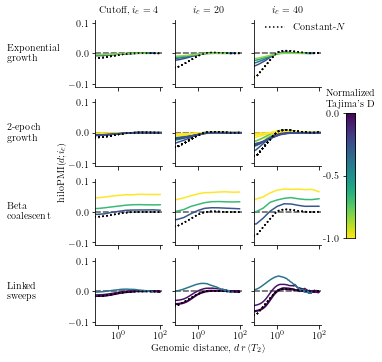

In [13]:
cutoffs = [4, 20, 40]
n_rows = 4
n_cols = len(cutoffs)

xscale = 1.5
yscale = 1.5
fig = plt.figure(figsize=(xscale*single_col_width, yscale*single_col_width))

x_text = 0.025 / xscale
x_panel = 0.25
x_cb = 0.9
panel_size = 0.265
panel_buffer = 0.05
panel_bottom = 0.1
panel_width = panel_size / xscale
panel_height = panel_size / yscale
panel_xbuffer = panel_buffer / xscale
panel_ybuffer = panel_buffer / yscale    

# EXP
axes = [fig.add_axes([x_panel + i*(panel_width+panel_xbuffer),
                      panel_bottom + 3*(panel_height+panel_ybuffer),
                      panel_width,
                      panel_height]) for i in range(n_cols)]
axes[0].set_title('Cutoff, $i_c = 4$')
axes[1].set_title('$i_c = 20$')
axes[2].set_title('$i_c = 40$')

axes = plot_row_msp(axes, *data_exp, cutoffs)
axes[-1].lines[-1].set_label('Constant-$N$')
axes[-1].legend(frameon=False, loc=(0.1,0.75))

# PWC
axes = [fig.add_axes([x_panel + i*(panel_width+panel_xbuffer),
                  panel_bottom + 2*(panel_height+panel_ybuffer),
                  panel_width,
                  panel_height]) for i in range(n_cols)]
#for i_t, t in enumerate(t_list):
axes = plot_row_msp(axes, *data_pwc, cutoffs)

# BETA
axes = [fig.add_axes([x_panel + i*(panel_width+panel_xbuffer),
                  panel_bottom + 1*(panel_height+panel_ybuffer),
                  panel_width,
                  panel_height]) for i in range(n_cols)]
axes = plot_row_msp(axes, *data_beta, cutoffs)

for ax in fig.get_axes():
    ax.set_xticklabels([])
    
# Sweeps
axes = [fig.add_axes([x_panel + i*(panel_width+panel_xbuffer),
                  panel_bottom,
                  panel_width,
                  panel_height]) for i in range(n_cols)]
for fsel, data in zip(fsels_sweeps, slim_data):
    axes = plot_row_slim(axes, *data, cutoffs)
axes[1].set_xlabel(r'Genomic distance, $d\,r \left< T_2 \right>$')
    
for ax in fig.get_axes():
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
ax = fig.add_axes([x_cb,0.33,0.05,0.33])
v = 1
norm = mpl.colors.Normalize(vmin=-v, vmax=v)
gradient = np.linspace(-v, v, 256)
gradient = np.vstack((gradient, gradient))
ax.imshow(gradient.T, aspect=0.1, norm=norm, cmap=plt.get_cmap('viridis_r'))
ax.set_xticks([])
ax.set_yticks([0,256//2,256])
ax.set_yticklabels([-1.0, -0.5, 0.0])
ax.set_ylim([0,256])
ax.set_title("Normalized\nTajima's D")


fig.text(x_text, panel_bottom + panel_height/2 + 3*(panel_height+panel_ybuffer), "Exponential\ngrowth", va='center')
fig.text(x_text, panel_bottom + panel_height/2 + 2*(panel_height+panel_ybuffer), "2-epoch\ngrowth", va='center')
fig.text(x_text, panel_bottom + panel_height/2 + (panel_height+panel_ybuffer), "Beta\ncoalescent", va='center')
fig.text(x_text, panel_bottom + panel_height/2, "Linked\nsweeps", va='center')

fig.text(0.15, panel_bottom + 2*panel_height + 1.5*panel_ybuffer, r"hiloPMI$(d;i_c)$", rotation=90, va="center")
fig.savefig('../manuscript/figures/hilopmi_vs_distance.pdf')
